In [2]:
# Import everything
from collections import deque
from imutils.video import VideoStream
import numpy as np
import argparse
import cv2
import imutils
import time


In [19]:
# Get video source
#vs = cv2.VideoCapture('./strike_lane/Halmon_X_1a.mp4',0)

# Reads in video, tracks the ball, outputs array of ball points/coordinates 
def analyzeVideo(videoName):
    vs = cv2.VideoCapture(videoName,0)
    print(vs)

    # allow the camera or video file to warm up
    time.sleep(2.0)

    # define the lower and upper boundaries of the "green"
    # ball in the HSV color space, then initialize the
    # list of tracked points
    #greenLower = (0, 180, 0) 
    #greenUpper = (30, 242, 182)
    greenLower = (6, 242, 61) 
    greenUpper = (40, 255, 200)
    pts = deque(maxlen=64)

    # keep looping
    xTemp = 0 #Initialize variables xTemp and yTemp
    yTemp = 0
    toggleFirst = 0
    while True:
        # grab the current frame
        #frame = vs.read()
        _, frame = vs.read()

        # if we are viewing a video and we did not grab a frame,
        # then we have reached the end of the video
        if frame is None:
            break

        (w, h, c) = frame.shape # shape the frame to allow w, h and c to be utilized later on

        # resize the frame, blur it, and convert it to the HSV
        # color space
        #frame = imutils.resize(frame, width=600)
        #frame = cv2.resize(frame,(600, w))
        blurred = cv2.GaussianBlur(frame, (11, 11), 0)
        hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

        # construct a mask for the color "green", then perform
        # a series of dilations and erosions to remove any small
        # blobs left in the mask
        mask = cv2.inRange(hsv, greenLower, greenUpper)
        mask = cv2.erode(mask, None, iterations=2)
        mask = cv2.dilate(mask, None, iterations=2)

        # find contours in the mask and initialize the current
        # (x, y) center of the ball
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        center = None

        # only proceed if at least one contour was found
        if len(cnts) > 0:
            # find the largest contour in the mask, then use
            # it to compute the minimum enclosing circle and
            # centroid
            c = max(cnts, key=cv2.contourArea)
            ((x, y), radius) = cv2.minEnclosingCircle(c)
            M = cv2.moments(c)
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

    #        # only proceed if the radius meets a minimum size
    #        if radius > 1:
    #            # draw the circle and centroid on the frame,
    #            # then update the list of tracked points
    #            cv2.circle(frame, (int(x), int(y)), int(radius),
    #                (0, 255, 255), 2)
    #            cv2.circle(frame, center, 5, (0, 0, 255), -1)


            if toggleFirst == 0: # check if first run
                if radius > 1: # only proceed if the radius meets a minimum size
                    # draw the circle and centroid on the frame,
                    # then update the list of tracked points
                    cv2.circle(frame, (int(x), int(y)), int(radius),
                        (0, 255, 255), 2)
                    cv2.circle(frame, center, 5, (0, 0, 255), -1)
                    toggleFirst = 1
                    xTemp = center[0]
                    yTemp = center[1]
            else: 
                if radius > 1:# only proceed if the radius meets a minimum size
                    if center[0] < xTemp + 50 and center[1] < yTemp + 50: # only proceed if x and y coordinates are near previous
                        # draw the circle and centroid on the frame,
                        # then update the list of tracked points
                        cv2.circle(frame, (int(x), int(y)), int(radius),
                            (0, 255, 255), 2)
                        cv2.circle(frame, center, 5, (0, 0, 255), -1)
                        xTemp = center[0]
                        yTemp = center[1]                    
                        pts.appendleft(center)


        # update the points queue
        #pts.appendleft(center)

        # loop over the set of tracked points
        for i in range(1, len(pts)):
            # if either of the tracked points are None, ignore
            # them
            if pts[i - 1] is None or pts[i] is None:
                continue

            # otherwise, compute the thickness of the line and
            # draw the connecting lines
            thickness = int(np.sqrt(64 / float(i + 1)) * 2.5)
            #thickness = 1
            cv2.line(frame, pts[i - 1], pts[i], (0, 255, 255), thickness)
            #print(pts[i])

        # show the frame to our screen
        #cv2.imshow("Frame", frame)
        key = cv2.waitKey(1) & 0xFF

        # if the 'q' key is pressed, stop the loop
        if key == ord("q"):
            break

    # Release the video capture
    vs.release()

    # close all windows
    cv2.destroyAllWindows()
    #print(pts)
    return pts

In [24]:
def visualizeData(pts):
    # Get x and y values for graphing
    xValues = np.array([])
    yValues = np.array([])
    for point in pts:
        xValues = np.append(xValues, point[0])
        yValues = np.append(yValues, point[1])
    print(pts)
    print(xValues)
    print(yValues)

    # Line of best poly fit
    from numpy.polynomial.polynomial import polyfit
    b, m = polyfit(xValues, yValues, 1)
    print("slope: " + str(abs(m)))
    
    # Graph it (this is for our own use only, does not help code. May be nice to show graphs in GUI???)
    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.plot(xValues, yValues, 'o')
    plt.plot(xValues, b + m * xValues, '-')
    plt.gca().invert_yaxis()
    plt.xlabel("X coordinates")
    plt.ylabel("Y coordinates")
    plt.title("Graph ball coordinates")

    plt.show()
    return(abs(m))

<VideoCapture 00000158D755B3B0>
deque([(931, 466), (928, 472), (924, 479), (919, 485), (914, 493), (909, 500), (903, 509), (896, 518), (889, 528), (881, 539), (873, 551), (857, 564)], maxlen=64)
[931. 928. 924. 919. 914. 909. 903. 896. 889. 881. 873. 857.]
[466. 472. 479. 485. 493. 500. 509. 518. 528. 539. 551. 564.]
slope: 1.3602401601067358


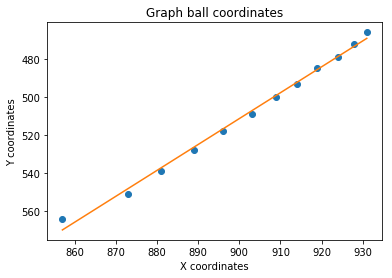

In [20]:
visualizeData(analyzeVideo('./strike_lane_edited/RX4a.mp4'))

./strike_lane_edited/RX1a.mp4
Ryan_X_1

<VideoCapture 00000158D6512CF0>
deque([(943, 371), (936, 383), (933, 387), (929, 394), (924, 401), (917, 409), (913, 417), (906, 426), (899, 437)], maxlen=64)
[943. 936. 933. 929. 924. 917. 913. 906. 899.]
[371. 383. 387. 394. 401. 409. 417. 426. 437.]
slope: 1.4695703278046115


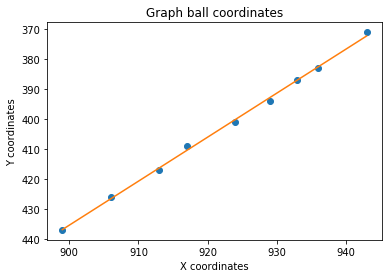

./strike_lane_edited/RX2a.mp4
Ryan_X_2

<VideoCapture 00000158D75DB730>
deque([(907, 524), (904, 529), (900, 536), (896, 541), (891, 548), (886, 554), (881, 562), (874, 571), (867, 580), (861, 591), (860, 604), (846, 616), (843, 631), (837, 647), (814, 686)], maxlen=64)
[907. 904. 900. 896. 891. 886. 881. 874. 867. 861. 860. 846. 843. 837.
 814.]
[524. 529. 536. 541. 548. 554. 562. 571. 580. 591. 604. 616. 631. 647.
 686.]
slope: 1.7123094473974452


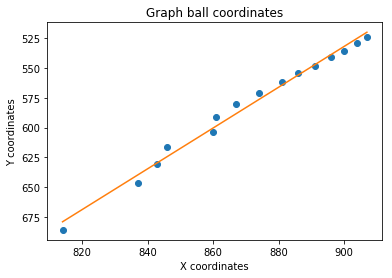

./strike_lane_edited/RX3a.mp4
Ryan_X_3

<VideoCapture 00000158D63CE970>
deque([(913, 462), (909, 468), (905, 473), (901, 479), (898, 484), (892, 493), (888, 498), (881, 509), (875, 515), (867, 529), (860, 536), (851, 555), (853, 565), (819, 582), (821, 602), (816, 630), (801, 655)], maxlen=64)
[913. 909. 905. 901. 898. 892. 888. 881. 875. 867. 860. 851. 853. 819.
 821. 816. 801.]
[462. 468. 473. 479. 484. 493. 498. 509. 515. 529. 536. 555. 565. 582.
 602. 630. 655.]
slope: 1.607489368494259


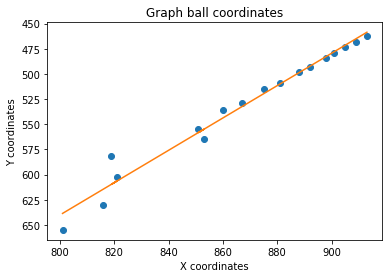

./strike_lane_edited/RX4a.mp4
Ryan_X_4

<VideoCapture 00000158D759A950>
deque([(931, 466), (928, 472), (924, 479), (919, 485), (914, 493), (909, 500), (903, 509), (896, 518), (889, 528), (881, 539), (873, 551), (857, 564)], maxlen=64)
[931. 928. 924. 919. 914. 909. 903. 896. 889. 881. 873. 857.]
[466. 472. 479. 485. 493. 500. 509. 518. 528. 539. 551. 564.]
slope: 1.3602401601067358


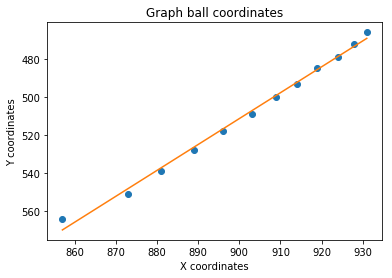

./strike_lane_edited/HX1a.mp4
Halmon_X_1

<VideoCapture 00000158D75DB3D0>
deque([(947, 393), (942, 399), (938, 408), (930, 414), (927, 421), (918, 429), (910, 440), (899, 450), (891, 461), (881, 473), (870, 488), (854, 502), (833, 517)], maxlen=64)
[947. 942. 938. 930. 927. 918. 910. 899. 891. 881. 870. 854. 833.]
[393. 399. 408. 414. 421. 429. 440. 450. 461. 473. 488. 502. 517.]
slope: 1.1210104911634824


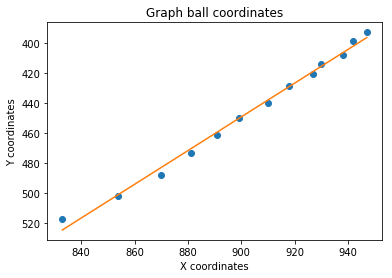

./strike_lane_edited/HX2a.mp4
Halmon_X_2

<VideoCapture 00000158D64412D0>
deque([(995, 411), (991, 417), (988, 425), (982, 432), (979, 438), (972, 447), (966, 459), (957, 467)], maxlen=64)
[995. 991. 988. 982. 979. 972. 966. 957.]
[411. 417. 425. 432. 438. 447. 459. 467.]
slope: 1.5065044062106665


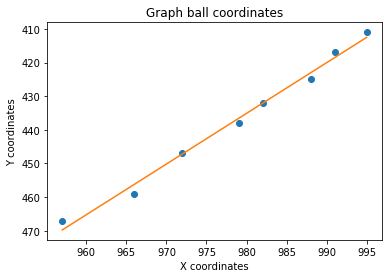

./strike_lane_edited/HX3a.mp4
Halmon_X_3

<VideoCapture 00000158D61319D0>
deque([(937, 421), (929, 431), (925, 436), (920, 442), (915, 449), (909, 455), (904, 461)], maxlen=64)
[937. 929. 925. 920. 915. 909. 904.]
[421. 431. 436. 442. 449. 455. 461.]
slope: 1.2145930441018318


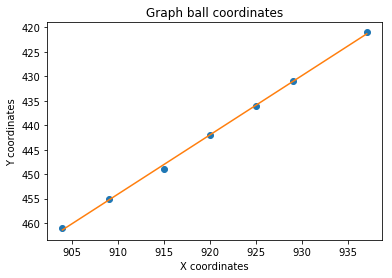

./strike_lane_edited/HX4a.mp4
Halmon_X_4

<VideoCapture 00000158D764B950>
deque([(918, 443), (914, 449), (908, 455), (903, 463), (901, 470), (897, 478)], maxlen=64)
[918. 914. 908. 903. 901. 897.]
[443. 449. 455. 463. 470. 478.]
slope: 1.6148683531233552


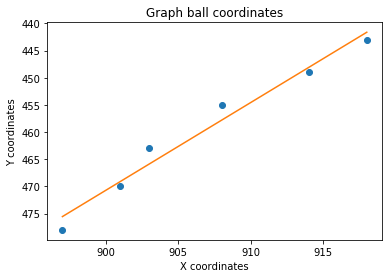

In [28]:
# Open the output file
text_file = open("StrikeBallSlope.txt", "w")


# Loop through the videos and write outputs to file
for x in range(1,5): # for Ryan's strikes
    name = './strike_lane_edited/RX'+ str(x) + 'a.mp4'
    outName = 'Ryan_X_' + str(x)+'\n'
    print(name)
    print(outName)
    text_file.write(outName)
    text_file.write(str(visualizeData(analyzeVideo(name)))+'\n')

for x in range(1,5): # for Halmon's strikes
    name = './strike_lane_edited/HX'+ str(x) + 'a.mp4'
    outName = 'Halmon_X_' + str(x)+'\n'
    print(name)
    print(outName)
    text_file.write(outName)
    text_file.write(str(visualizeData(analyzeVideo(name)))+'\n')
text_file.close()

./not_strike_lane_edited/RO1a.mp4
Ryan_O_1

<VideoCapture 00000158D63BD190>
deque([(971, 445), (967, 449), (964, 455), (960, 460), (955, 466), (950, 472), (945, 480), (939, 487), (932, 497), (925, 507), (917, 518), (909, 531), (900, 543), (891, 556), (878, 571), (857, 587)], maxlen=64)
[971. 967. 964. 960. 955. 950. 945. 939. 932. 925. 917. 909. 900. 891.
 878. 857.]
[445. 449. 455. 460. 466. 472. 480. 487. 497. 507. 518. 531. 543. 556.
 571. 587.]
slope: 1.3203084832904826


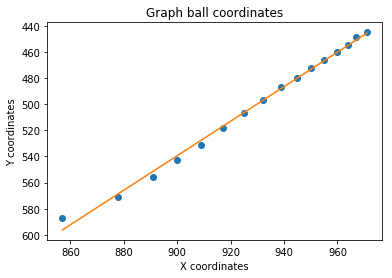

./not_strike_lane_edited/RO2a.mp4
Ryan_O_2

<VideoCapture 00000158D764B930>
deque([(935, 516), (932, 521), (929, 526), (926, 532), (921, 539), (918, 545), (913, 552), (909, 560), (903, 568)], maxlen=64)
[935. 932. 929. 926. 921. 918. 913. 909. 903.]
[516. 521. 526. 532. 539. 545. 552. 560. 568.]
slope: 1.640944326990821


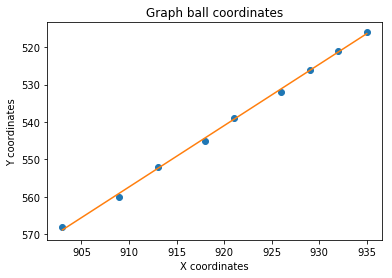

./not_strike_lane_edited/RO3a.mp4
Ryan_O_3

<VideoCapture 00000158D63BD6D0>
deque([(937, 526), (934, 532), (928, 539), (923, 546), (918, 552), (912, 560), (907, 569), (903, 578), (895, 588), (885, 599), (884, 612)], maxlen=64)
[937. 934. 928. 923. 918. 912. 907. 903. 895. 885. 884.]
[526. 532. 539. 546. 552. 560. 569. 578. 588. 599. 612.]
slope: 1.5097893563962521


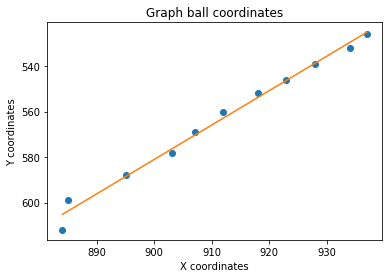

./not_strike_lane_edited/RO4a.mp4
Ryan_O_4

<VideoCapture 00000158D64B3B10>
deque([(945, 430), (940, 435), (935, 441), (931, 447), (925, 455), (920, 460), (913, 471), (908, 476), (900, 490), (893, 495), (882, 514), (861, 542)], maxlen=64)
[945. 940. 935. 931. 925. 920. 913. 908. 900. 893. 882. 861.]
[430. 435. 441. 447. 455. 460. 471. 476. 490. 495. 514. 542.]
slope: 1.3435060073442888


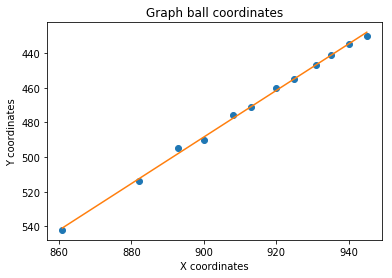

./not_strike_lane_edited/RO5a.mp4
Ryan_O_5

<VideoCapture 00000158D6316C70>
deque([(907, 453), (903, 459), (900, 465), (891, 471), (885, 479), (878, 486), (871, 495), (863, 505), (854, 516), (844, 526), (844, 541), (823, 554), (811, 571), (807, 596), (790, 622)], maxlen=64)
[907. 903. 900. 891. 885. 878. 871. 863. 854. 844. 844. 823. 811. 807.
 790.]
[453. 459. 465. 471. 479. 486. 495. 505. 516. 526. 541. 554. 571. 596.
 622.]
slope: 1.3675847529437275


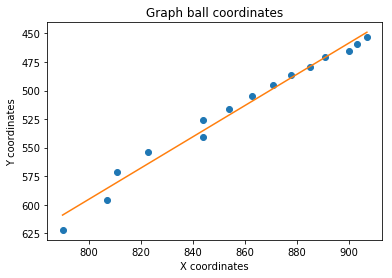

./not_strike_lane_edited/RO6a.mp4
Ryan_O_6

<VideoCapture 00000158D63BDF30>
deque([(952, 495), (948, 501), (944, 506), (939, 513), (933, 520), (930, 526), (925, 534), (919, 542), (912, 551), (904, 562), (896, 573), (880, 616), (852, 656), (834, 681)], maxlen=64)
[952. 948. 944. 939. 933. 930. 925. 919. 912. 904. 896. 880. 852. 834.]
[495. 501. 506. 513. 520. 526. 534. 542. 551. 562. 573. 616. 656. 681.]
slope: 1.611704681872746


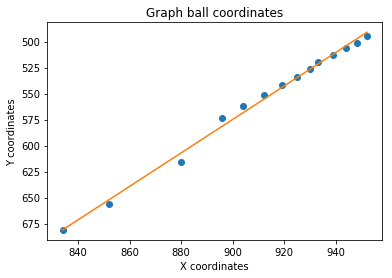

./not_strike_lane_edited/RO7a.mp4
Ryan_O_7

<VideoCapture 00000158D7676090>
deque([(934, 443), (929, 450), (925, 457), (919, 465), (914, 473), (907, 482), (901, 493), (893, 504), (884, 516), (876, 529), (866, 544), (854, 562), (852, 583), (840, 603)], maxlen=64)
[934. 929. 925. 919. 914. 907. 901. 893. 884. 876. 866. 854. 852. 840.]
[443. 450. 457. 465. 473. 482. 493. 504. 516. 529. 544. 562. 583. 603.]
slope: 1.6296461594799945


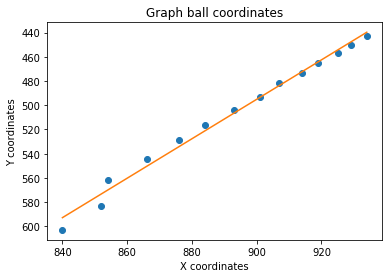

./not_strike_lane_edited/RO8a.mp4
Ryan_O_8

<VideoCapture 00000158D64F3C50>
deque([(917, 456), (909, 468), (897, 484), (891, 494), (883, 505)], maxlen=64)
[917. 909. 897. 891. 883.]
[456. 468. 484. 494. 505.]
slope: 1.4384368308351057


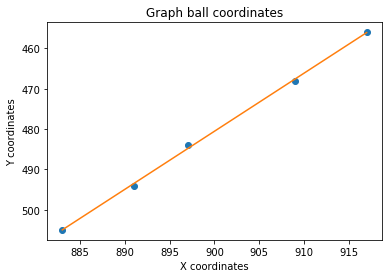

./not_strike_lane_edited/RO9a.mp4
Ryan_O_9

<VideoCapture 00000158D6493F90>
deque([(929, 473), (927, 480), (923, 486), (920, 493), (917, 501), (913, 508), (909, 517), (904, 526), (898, 536), (892, 548)], maxlen=64)
[929. 927. 923. 920. 917. 913. 909. 904. 898. 892.]
[473. 480. 486. 493. 501. 508. 517. 526. 536. 548.]
slope: 2.001014786894762


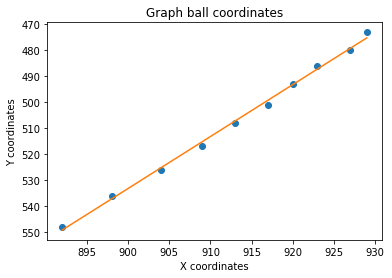

./not_strike_lane_edited/HO1a.mp4
Halmon_O_1

<VideoCapture 00000158D75F88B0>
deque([(920, 405), (915, 412), (911, 420), (904, 428), (900, 435), (892, 445)], maxlen=64)
[920. 915. 911. 904. 900. 892.]
[405. 412. 420. 428. 435. 445.]
slope: 1.4342105263157645


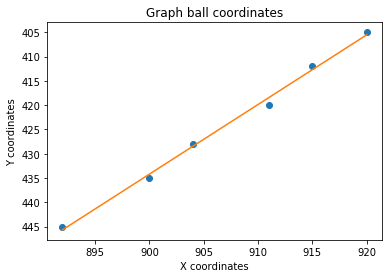

./not_strike_lane_edited/HO2a.mp4
Halmon_O_2

<VideoCapture 00000158D754D910>
deque([(918, 413)], maxlen=64)
[918.]
[413.]
slope: 0.22494553376906315


C:\Users\luih\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RankWarning: The fit may be poorly conditioned
  


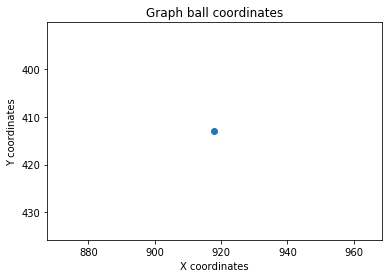

./not_strike_lane_edited/HO3a.mp4
Halmon_O_3

<VideoCapture 00000158D759A0D0>
deque([(976, 420), (972, 427), (968, 433), (964, 440), (960, 446), (954, 454), (949, 464)], maxlen=64)
[976. 972. 968. 964. 960. 954. 949.]
[420. 427. 433. 440. 446. 454. 464.]
slope: 1.5908396946564904


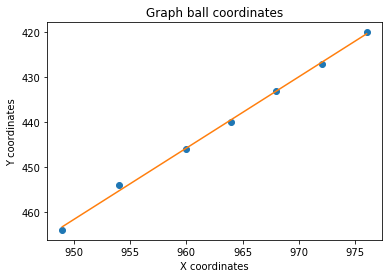

./not_strike_lane_edited/HO4a.mp4
Halmon_O_4

<VideoCapture 00000158D765FFB0>
deque([(952, 404), (949, 410), (941, 419), (937, 425), (932, 432), (928, 439)], maxlen=64)
[952. 949. 941. 937. 932. 928.]
[404. 410. 419. 425. 432. 439.]
slope: 1.4012043658260893


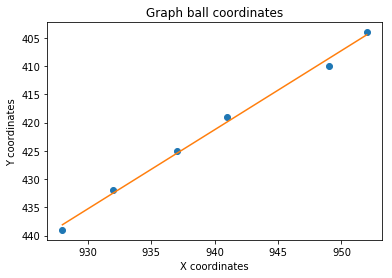

./not_strike_lane_edited/HO5a.mp4
Halmon_O_5

<VideoCapture 00000158D754D910>
deque([(905, 408), (902, 414), (899, 420), (896, 426), (893, 432), (888, 439), (884, 447), (879, 455), (871, 463), (866, 474), (860, 485), (852, 497), (842, 509), (832, 523), (812, 536), (823, 559), (810, 582), (795, 605)], maxlen=64)
[905. 902. 899. 896. 893. 888. 884. 879. 871. 866. 860. 852. 842. 832.
 812. 823. 810. 795.]
[408. 414. 420. 426. 432. 439. 447. 455. 463. 474. 485. 497. 509. 523.
 536. 559. 582. 605.]
slope: 1.6718957794028977


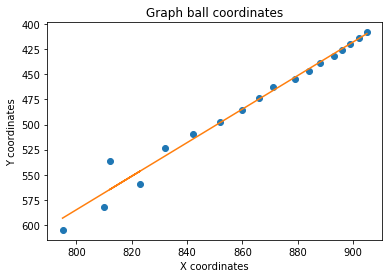

./not_strike_lane_edited/HO6a.mp4
Halmon_O_6

<VideoCapture 00000158D6493890>
deque([(910, 568), (906, 573), (902, 579), (898, 585), (893, 592), (890, 599), (886, 608), (886, 616), (879, 625), (871, 637), (862, 647), (853, 659), (853, 676), (846, 692), (807, 757)], maxlen=64)
[910. 906. 902. 898. 893. 890. 886. 886. 879. 871. 862. 853. 853. 846.
 807.]
[568. 573. 579. 585. 592. 599. 608. 616. 625. 637. 647. 659. 676. 692.
 757.]
slope: 1.8622638958868392


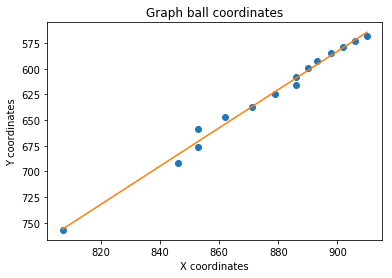

./not_strike_lane_edited/HO7a.mp4
Halmon_O_7

<VideoCapture 00000158D6407050>
deque([(910, 568), (906, 573), (902, 579), (898, 585), (893, 592), (890, 599), (886, 608), (886, 616), (879, 625), (871, 637), (862, 647), (853, 659), (853, 676), (846, 692), (807, 757)], maxlen=64)
[910. 906. 902. 898. 893. 890. 886. 886. 879. 871. 862. 853. 853. 846.
 807.]
[568. 573. 579. 585. 592. 599. 608. 616. 625. 637. 647. 659. 676. 692.
 757.]
slope: 1.8622638958868392


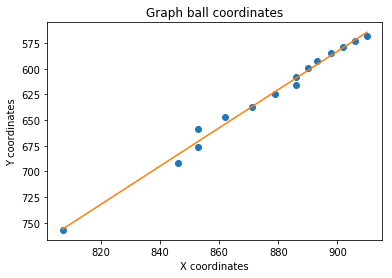

./not_strike_lane_edited/HO8a.mp4
Halmon_O_8

<VideoCapture 00000158D7590FD0>
deque([(925, 445), (922, 451), (918, 458), (914, 464), (913, 470), (904, 478), (899, 487), (892, 495), (885, 505), (877, 516), (870, 528), (856, 539), (846, 553)], maxlen=64)
[925. 922. 918. 914. 913. 904. 899. 892. 885. 877. 870. 856. 846.]
[445. 451. 458. 464. 470. 478. 487. 495. 505. 516. 528. 539. 553.]
slope: 1.3502393834416684


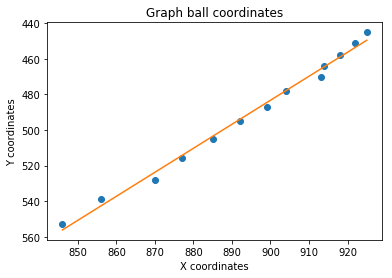

./not_strike_lane_edited/HO9a.mp4
Halmon_O_9

<VideoCapture 00000158D75909B0>
deque([(908, 473), (903, 481), (897, 490), (890, 499), (883, 510), (875, 521), (865, 534), (855, 548), (845, 563), (830, 581), (819, 633)], maxlen=64)
[908. 903. 897. 890. 883. 875. 865. 855. 845. 830. 819.]
[473. 481. 490. 499. 510. 521. 534. 548. 563. 581. 633.]
slope: 1.5893416927899733


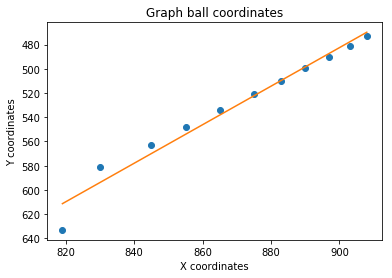

./not_strike_lane_edited/HO10a.mp4
Halmon_O_10

<VideoCapture 00000158D7588110>
deque([(918, 413)], maxlen=64)
[918.]
[413.]
slope: 0.22494553376906315


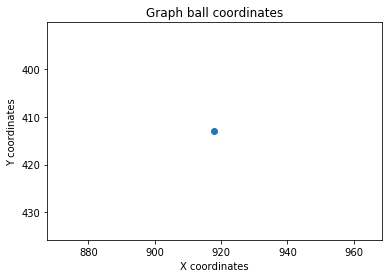

./not_strike_lane_edited/HO11a.mp4
Halmon_O_11

<VideoCapture 00000158D642D150>
deque([(952, 404), (949, 410), (941, 419), (937, 425), (932, 432), (928, 439)], maxlen=64)
[952. 949. 941. 937. 932. 928.]
[404. 410. 419. 425. 432. 439.]
slope: 1.4012043658260893


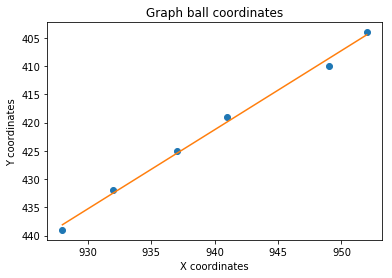

./not_strike_lane_edited/HO12a.mp4
Halmon_O_12

<VideoCapture 00000158D759A370>
deque([(934, 443), (931, 450), (925, 457), (919, 465), (914, 473), (908, 482), (901, 493), (893, 503), (884, 516), (876, 529), (865, 544), (854, 562), (852, 583), (840, 604), (824, 629)], maxlen=64)
[934. 931. 925. 919. 914. 908. 901. 893. 884. 876. 865. 854. 852. 840.
 824.]
[443. 450. 457. 465. 473. 482. 493. 503. 516. 529. 544. 562. 583. 604.
 629.]
slope: 1.6575470595112827


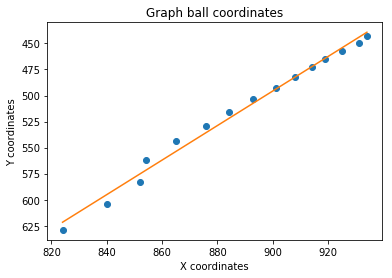

./not_strike_lane_edited/HO13a.mp4
Halmon_O_13

<VideoCapture 00000158D7588110>
deque([(905, 408), (902, 414), (899, 420), (896, 426), (893, 432), (888, 439), (884, 447), (879, 455), (871, 463), (866, 474), (860, 485), (852, 497), (842, 509), (832, 523), (812, 536), (823, 559), (810, 582), (795, 605)], maxlen=64)
[905. 902. 899. 896. 893. 888. 884. 879. 871. 866. 860. 852. 842. 832.
 812. 823. 810. 795.]
[408. 414. 420. 426. 432. 439. 447. 455. 463. 474. 485. 497. 509. 523.
 536. 559. 582. 605.]
slope: 1.6718957794028977


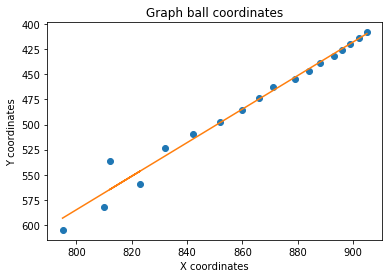

./not_strike_lane_edited/HO14a.mp4
Halmon_O_14

<VideoCapture 00000158D63EABD0>
deque([(929, 473), (927, 480), (923, 486), (920, 493), (917, 501), (913, 508), (909, 517), (904, 526), (898, 536), (892, 548)], maxlen=64)
[929. 927. 923. 920. 917. 913. 909. 904. 898. 892.]
[473. 480. 486. 493. 501. 508. 517. 526. 536. 548.]
slope: 2.001014786894762


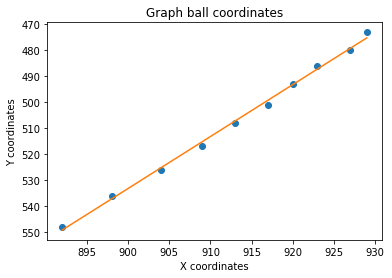

In [30]:
# Open the output file
text_file = open("NotStrikeBallSlope.txt", "w")


# Loop through the videos and write outputs to file
for x in range(1,10): # for Ryan's strikes
    name = './not_strike_lane_edited/RO'+ str(x) + 'a.mp4'
    outName = 'Ryan_O_' + str(x)+'\n'
    print(name)
    print(outName)
    text_file.write(outName)
    text_file.write(str(visualizeData(analyzeVideo(name)))+'\n')

for x in range(1,15): # for Halmon's strikes
    name = './not_strike_lane_edited/HO'+ str(x) + 'a.mp4'
    outName = 'Halmon_O_' + str(x)+'\n'
    print(name)
    print(outName)
    text_file.write(outName)
    text_file.write(str(visualizeData(analyzeVideo(name)))+'\n')
text_file.close()